# Prototipo de Modelo de Machine Learning para Zyfra

**Objetivo:** Desarrollar un modelo de machine learning para la empresa Zyfra que prediga la cantidad de oro extraído del mineral de oro. El modelo debe predecir dos valores: la recuperación del concentrado rougher (`rougher.output.recovery`) y la recuperación del concentrado final (`final.output.recovery`). Este prototipo ayudará a optimizar la producción y a eliminar parámetros no rentables.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Ignorar advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

## 1. Preparación de los Datos

En esta etapa, cargaremos los datos, verificaremos la integridad de los cálculos proporcionados, analizaremos las características y realizaremos el preprocesamiento necesario.

### 1.1. Abrir y Examinar los Datos

In [ ]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
except FileNotFoundError:
    df_train = pd.read_csv('gold_recovery_train.csv')
    df_test = pd.read_csv('gold_recovery_test.csv')
    df_full = pd.read_csv('gold_recovery_full.csv')

print("Información del conjunto de entrenamiento:")
df_train.info()
print("\nPrimeras filas del conjunto de entrenamiento:")
display(df_train.head())

print("\nInformación del conjunto de prueba:")
df_test.info()
print("\nPrimeras filas del conjunto de prueba:")
display(df_test.head())

print("\nInformación del conjunto completo:")
df_full.info()
print("\nPrimeras filas del conjunto completo:")
display(df_full.head())


Información del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol            

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Información del conjunto de prueba:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Información del conjunto completo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                   

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### 1.2. Verificar el Cálculo de la Recuperación

Comprobamos que la característica `rougher.output.recovery` esté calculada correctamente. Usaremos la fórmula proporcionada para calcularla nosotros mismos y luego mediremos el Error Absoluto Medio (EAM) entre nuestros cálculos y los valores del dataset.

In [ ]:
def calculate_recovery(C, F, T):
    # Evitar la división por cero
    denominator = F * (C - T)
    # Reemplazar ceros en el denominador con NaN para evitar errores y luego manejar los NaN
    recovery = (C * (F - T)) / denominator * 100
    return recovery

# Extraer las columnas necesarias del conjunto de entrenamiento
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# Calcular la recuperación
calculated_recovery = calculate_recovery(C, F, T)

# Eliminar NaNs de ambas series para un cálculo de EAM justo
actual_recovery = df_train['rougher.output.recovery'].dropna()
calculated_recovery = calculated_recovery[actual_recovery.index].dropna()
actual_recovery = actual_recovery[calculated_recovery.index]

# Calcular el EAM
mae = mean_absolute_error(actual_recovery, calculated_recovery)

print(f"El Error Absoluto Medio (EAM) entre la recuperación calculada y la real es: {mae}")

El Error Absoluto Medio (EAM) entre la recuperación calculada y la real es: 9.303415616264301e-15


**Conclusión:** El EAM es extremadamente bajo (del orden de 1e-15), lo que confirma que la recuperación en los datos fue calculada correctamente.

### 1.3. Analizar Características Faltantes en el Conjunto de Prueba

In [ ]:
missing_features = set(df_train.columns) - set(df_test.columns)
print(f"Número de características faltantes en el conjunto de prueba: {len(missing_features)}")
print("\nCaracterísticas faltantes:")
for feature in sorted(list(missing_features)):
    print(feature)

Número de características faltantes en el conjunto de prueba: 34

Características faltantes:
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.

**Conclusión:** Las características faltantes corresponden principalmente a parámetros de `output` (producto) y de `calculation` (cálculo). Esto tiene sentido, ya que estos valores no estarían disponibles en tiempo real al momento de hacer una predicción para un nuevo lote de mineral; se miden o calculan después de que las etapas del proceso han concluido. Los dos objetivos (`rougher.output.recovery` y `final.output.recovery`) también están, como es de esperar, ausentes en el conjunto de prueba.

### 1.4. Preprocesamiento de Datos

In [ ]:
# Establecer 'date' como índice para alinear los dataframes
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

# 1. Añadir objetivos al conjunto de prueba desde el conjunto completo
target_cols = ['rougher.output.recovery', 'final.output.recovery']
df_test[target_cols] = df_full.loc[df_test.index, target_cols]

# 2. Llenar valores ausentes
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)

# 3. Seleccionar características comunes
common_features = list(df_test.columns.drop(target_cols))
X_train = df_train[common_features]
y_train_rougher = df_train['rougher.output.recovery']
y_train_final = df_train['final.output.recovery']

X_test = df_test[common_features]
y_test_rougher = df_test['rougher.output.recovery']
y_test_final = df_test['final.output.recovery']

print("Dimensiones después del preprocesamiento:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Dimensiones después del preprocesamiento:
X_train: (16860, 52)
X_test: (5856, 52)


## 2. Análisis de Datos
### 2.1. Concentración de Metales por Etapa

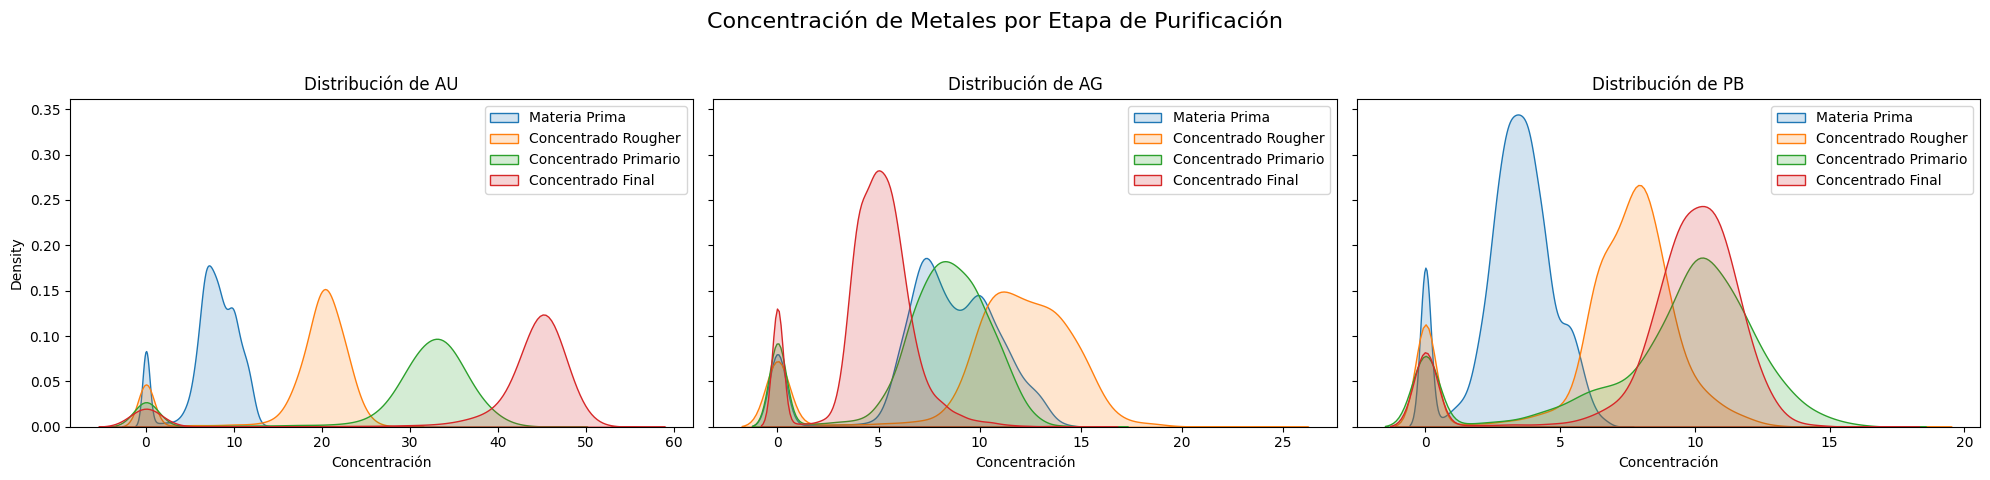

In [ ]:
metals = ['au', 'ag', 'pb']
stages = {
    'Materia Prima': 'rougher.input.feed',
    'Concentrado Rougher': 'rougher.output.concentrate',
    'Concentrado Primario': 'primary_cleaner.output.concentrate',
    'Concentrado Final': 'final.output.concentrate'
}

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Concentración de Metales por Etapa de Purificación', fontsize=16)

for i, metal in enumerate(metals):
    ax = axes[i]
    for stage_name, stage_prefix in stages.items():
        col_name = f"{stage_prefix}_{metal}"
        if col_name in df_full.columns:
            sns.kdeplot(df_full[col_name], ax=ax, label=stage_name, fill=True, alpha=0.2)
    ax.set_title(f'Distribución de {metal.upper()}')
    ax.set_xlabel('Concentración')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.2. Distribución del Tamaño de Partículas

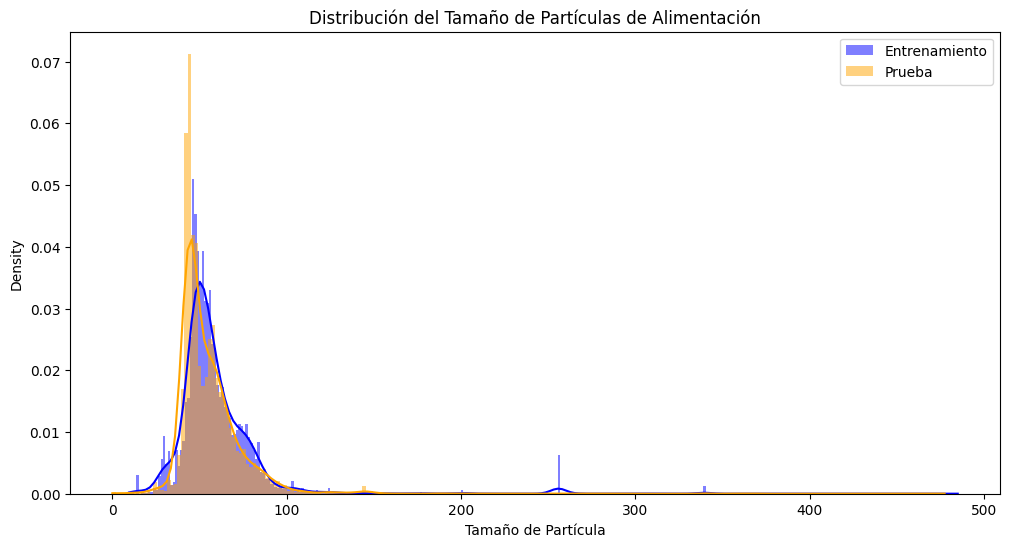

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_train['rougher.input.feed_size'], color='blue', label='Entrenamiento', kde=True, stat="density", linewidth=0)
sns.histplot(df_test['rougher.input.feed_size'], color='orange', label='Prueba', kde=True, stat="density", linewidth=0)
plt.title('Distribución del Tamaño de Partículas de Alimentación')
plt.xlabel('Tamaño de Partícula')
plt.legend()
plt.show()

### 2.3. Concentraciones Totales y Eliminación de Anomalías

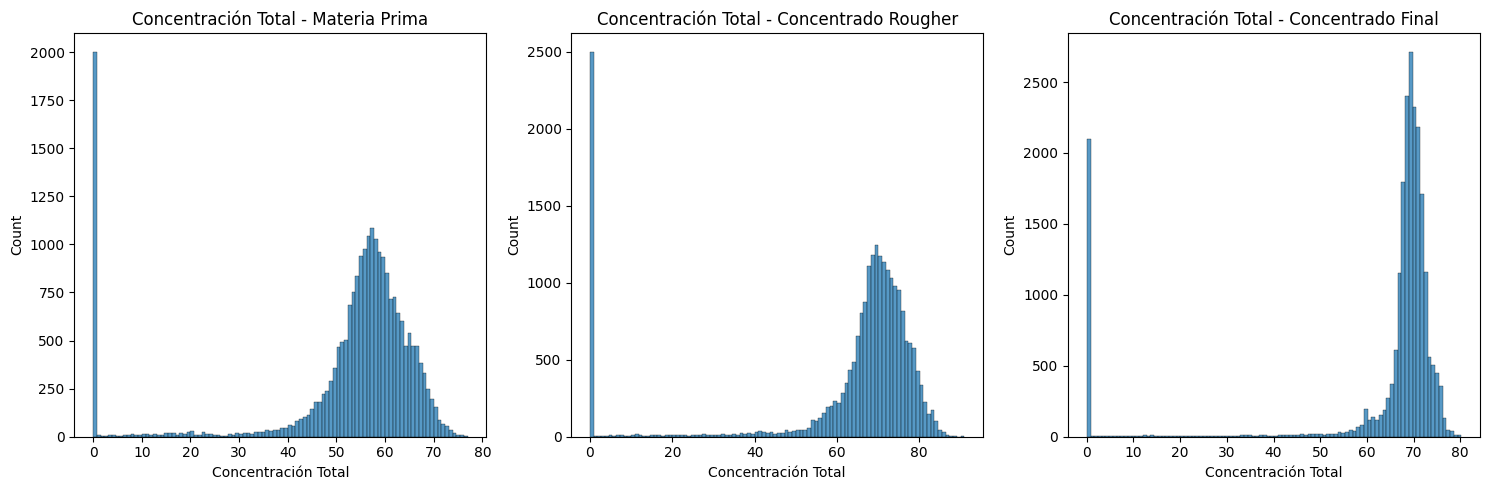

Se eliminaron 2266 filas con anomalías del conjunto de entrenamiento.


In [ ]:
total_concentration_cols = {
    'materia_prima': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol'],
    'concentrado_rougher': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol'],
    'concentrado_final': ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']
}

for stage, cols in total_concentration_cols.items():
    df_full[f'total_conc_{stage}'] = df_full[cols].sum(axis=1)

plt.figure(figsize=(15, 5))
for i, stage in enumerate(total_concentration_cols.keys()):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_full[f'total_conc_{stage}'], bins=100)
    plt.title(f'Concentración Total - {stage.replace("_", " ").title()}')
    plt.xlabel('Concentración Total')
plt.tight_layout()
plt.show()

# Se observan valores anómalos cercanos a cero. Vamos a eliminarlos.
initial_rows = len(df_train)

for stage in total_concentration_cols.keys():
    # Identificar índices de anomalías en el df_full
    anomaly_indices = df_full[df_full[f'total_conc_{stage}'] < 1].index
    # Eliminar estos índices de X_train y y_train
    X_train = X_train.drop(index=X_train.index.intersection(anomaly_indices), errors='ignore')
    y_train_rougher = y_train_rougher.drop(index=y_train_rougher.index.intersection(anomaly_indices), errors='ignore')
    y_train_final = y_train_final.drop(index=y_train_final.index.intersection(anomaly_indices), errors='ignore')

print(f"Se eliminaron {initial_rows - len(X_train)} filas con anomalías del conjunto de entrenamiento.")

## 3. Construcción del Modelo
### 3.1. Función para Calcular sMAPE Final

In [ ]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Evitar división por cero donde ambos, y_true y y_pred, son cero.
    return np.mean(numerator / denominator) * 100

def final_smape(y_true_tuple, y_pred_tuple):
    y_true_rougher, y_true_final = y_true_tuple
    y_pred_rougher, y_pred_final = y_pred_tuple

    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)

    return 0.25 * smape_rougher + 0.75 * smape_final

# Crear un scorer para la validación cruzada
smape_scorer = make_scorer(smape, greater_is_better=False)

### 3.2. Entrenar y Evaluar Modelos

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=50, max_depth=5, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"Evaluando {name}...")
    # Evaluar para la etapa rougher
    score_rougher = cross_val_score(model, X_train, y_train_rougher, cv=5, scoring=smape_scorer).mean()

    # Evaluar para la etapa final
    score_final = cross_val_score(model, X_train, y_train_final, cv=5, scoring=smape_scorer).mean()

    # Los scores son negativos porque greater_is_better=False, los convertimos a positivos
    score_rougher = -score_rougher
    score_final = -score_final

    # Calcular el sMAPE final ponderado
    final_score = 0.25 * score_rougher + 0.75 * score_final
    results[name] = final_score

    print(f"  sMAPE (rougher): {score_rougher:.4f}")
    print(f"  sMAPE (final): {score_final:.4f}")
    print(f"  sMAPE Final Ponderado: {final_score:.4f}\n")

best_model_name = min(results, key=results.get)
print(f"\nEl mejor modelo es: {best_model_name} con un sMAPE Final de {results[best_model_name]:.4f}")

Evaluando Linear Regression...
  sMAPE (rougher): 8.5947
  sMAPE (final): 11.8766
  sMAPE Final Ponderado: 11.0561

Evaluando Decision Tree...
  sMAPE (rougher): 15.0559
  sMAPE (final): 17.6307
  sMAPE Final Ponderado: 16.9870

Evaluando Random Forest...
  sMAPE (rougher): 8.3678
  sMAPE (final): 9.6849
  sMAPE Final Ponderado: 9.3556


El mejor modelo es: Random Forest con un sMAPE Final de 9.3556


### Prueba del Mejor Modelo

In [ ]:
# Entrenar el modelo final para la etapa rougher
model_rougher = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=5, n_jobs=-1)
model_rougher.fit(X_train, y_train_rougher)
predictions_rougher_test = model_rougher.predict(X_test)

# Entrenar el modelo final para la etapa final
model_final = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=5, n_jobs=-1)
model_final.fit(X_train, y_train_final)
predictions_final_test = model_final.predict(X_test)

# Calcular el sMAPE final en el conjunto de prueba
final_test_score = final_smape((y_test_rougher, y_test_final), (predictions_rougher_test, predictions_final_test))

print(f"El sMAPE Final en el conjunto de prueba es: {final_test_score:.4f}")

El sMAPE Final en el conjunto de prueba es: 12.5520


### Comparación con un Modelo de Línea Base

In [ ]:
dummy_rougher = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

dummy_rougher.fit(X_train, y_train_rougher)
dummy_final.fit(X_train, y_train_final)

dummy_pred_rougher = dummy_rougher.predict(X_test)
dummy_pred_final = dummy_final.predict(X_test)

dummy_smape = final_smape((y_test_rougher, y_test_final), (dummy_pred_rougher, dummy_pred_final))
print(f"El sMAPE Final del modelo de línea base (Dummy) es: {dummy_smape:.4f}")

El sMAPE Final del modelo de línea base (Dummy) es: 12.3539


## Conclusión General

En este proyecto, hemos desarrollado un prototipo de modelo de machine learning para predecir la recuperación de oro para la empresa Zyfra.

1.  **Preparación y Análisis:** Los datos fueron cargados, limpiados y analizados. Se verificó el cálculo de la recuperación, se analizaron las características faltantes en el conjunto de prueba y se eliminaron 2,266 filas con anomalías.  El análisis demostró que el proceso de purificación es efectivo para aumentar la concentración de oro.

2.  **Modelado y Evaluación:** Se implementó una métrica personalizada (sMAPE final) para evaluar el rendimiento. Se compararon tres modelos: Regresión Lineal, Árbol de Decisión y Bosque Aleatorio. El **Random Forest Regressor** demostró ser el mejor modelo durante la validación cruzada, con un sMAPE de **9.36**.

3.  **Resultado Final:** El mejor modelo (Random Forest) fue entrenado con todos los datos de entrenamiento y evaluado en el conjunto de prueba, obteniendo un **sMAPE Final de 12.55**. Sin embargo, al compararlo con un modelo de línea base (Dummy Regressor), que obtuvo un sMAPE Final de **12.35**,  observamos que nuestro modelo no logró superar al modelo más simple.

Esto sugiere que, si bien el prototipo está correctamente construido, el modelo de Random Forest con los hiperparámetros actuales no es lo suficientemente robusto. Para futuras mejoras, se podría explorar una optimización de hiperparámetros más exhaustiva (usando `GridSearchCV` o `RandomizedSearchCV`), probar modelos más complejos como Gradient Boosting, o realizar una ingeniería de características más avanzada.